<a href="https://colab.research.google.com/github/kimhwijin/TensorflowWithKeras/blob/master/GAN/ProGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers, datasets, optimizers

from tensorflow.keras.applications.inception_v3 import InceptionV3

import matplotlib.pyplot as plt
import sys
import numpy as np

In [ ]:
class ProGAN():
  def __init__(self, rows, cols, channels, z=10):
    #input shape
    self.img_rows = rows
    self.img_cols = cols
    self.channels = channels
    self.img_shape = (self.img_rows, self.img_cols, self.channels)
    self.generated_shape = (2, 2, 1)
    self.latent_dim = z

    optimizer = optimizers.Adam(0.0002, 0.5)
    
    #build and compile the discriminator
    self.discriminator = self.build_discriminator()
    self.discriminator.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    #build the generator
    self.generator = self.build_generator()

    #the generator takes noise as input and generates imgs
    z = tf.keras.Input(shape=(self.latent_dim,))
    img = self.generator(z)

    # The discriminator takes generated images as input and determines validity
    valid = self.discriminator(img)

    #생성기 판별기 결합
    self.combined = models.Model(z, valid)
    self.combined.compile(loss='binary_crossentropy', optimizer=optimizer)

  def build_generator(self):

    model = models.Sequential()

    model.add(layers.Dense(128 * 2 * 2, activation="relu", input_dim=10))
    model.add(layers.Reshape((2, 2, 128)))

    model.add(layers.Conv2DTranspose(128,kernel_size=3))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.Conv2DTranspose(128,kernel_size=3))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.add(layers.Conv2DTranspose(64,kernel_size=3))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.Activation("relu"))

    model.summary()

    noise = tf.keras.Input(shape=(self.latent_dim,))
    img = model(noise)

    return models.Model(noise, img)

  def build_discriminator(self):
    print("gener")
    model = models.Sequential()

    model.add(layers.Conv2D(32, kernel_size=3, strides=2, input_shape=self.generated_shape, padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(64, kernel_size=3, strides=2, padding='same'))
    model.add(layers.ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(layers.BatchNormalization(momentum=0.8))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dropout(0.25))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()

    img = tf.keras.Input(shape=self.generated_shape)
    validity = model(img)

    return models.Model(img, validity)


  def train(self, epochs, batch_size=256, save_interval=50):
    #load dataset
    (X_train, y_train), (x_test, y_test) = datasets.mnist.load_data()

    #Rescale -1 to 1
    X_train = X_train / 127.5 -1.
    X_train = np.expand_dims(X_train, axis=3)

    #Adversarial ground truths
    valid = np.ones((batch_size, 1))
    fake = np.zeros((batch_size, 1))

    for epoch in range(epochs):

      #판별기 훈련

      #이미지의 랜덤 절반 선택
      idx = np.random.randint(0, X_train.shape[0], batch_size)
      imgs = X_train[idx]

      #noise 생성
      noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
      gen_imgs = self.generator.predict(noise)

      r = np.concatenate([imgs, gen_imgs], axis=0)
      p_y = np.mean(r, axis=0)
      e = r*np.log(r/p_y)
      e = np.sum(e, axis=1)
      e = np.mean(e, axis=0)
      e = np.exp(e)
      print("Inception Score : ",end='')
      print(e)



      #판별기 훈련 (진짜이미지 1 , 가짜 이미지 0)
      d_loss_real = self.discriminator.train_on_batch(imgs, valid)
      d_loss_fake = self.discriminator.train_on_batch(gen_imgs, fake)
      d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

      #생성기 훈련

      #판별기의 값이 1이 되도록
      g_loss = self.combined.train_on_batch(noise, valid)

      
      print('%d [D loss : %f, acc : %.2f%%] [G loss : %f]' %(epoch, d_loss[0], 100*d_loss[1], g_loss))
      
      if epoch % save_interval == 0:
        self.save_imgs(epoch)
        
  def save_imgs(self, epoch):
    r, c = 5, 5
    noise = np.random.normal(0, 1, (r * c, self.latent_dim))
    gen_imgs = self.generator.predict(noise)

    #Rescale image 0 - 1
    gen_imgs = 0.5 * gen_imgs + 0.5

    fig, axs = plt.subplots(r,c)
    cnt = 0
    for i in range(r):
      for j in range(c):
        axs[i,j].imshow(gen_imgs[cnt, :,:,0], cmap='gray')
        axs[i,j].axis('off')
        cnt += 1
    fig.savefig('drive/MyDrive/Colab Notebooks/result_data/dcgan_mnist_%d.png' % epoch)

    plt.close()

In [ ]:
progan = ProGAN(28, 28, 1)

In [ ]:
model = create_model()
checkpoint_path = "drive/MyDrive/Colab Notebooks/models/MNIST/cp.ckpt"
model.load_weights(checkpoint_path)

In [ ]:
def upscale_layer(layer, upscale_factor):
  height, width = layer.get_shape[1:3]
  size = (upscale_factor * height , upscale_factor * width)
  upscaled_layer = tf.image.resize_nearest_neighbor(layer, size)

  return upscaled_layer

In [ ]:
def smoothly_image_last_layer(list_of_layers, alpha):
  last_fully_trained_layer = list_of_layers[-2]
  last_layer_upscaled = upscale_layer(last_fully_trained_layer, 2)

  larger_native_layer = list_of_layers[-1]

  assert larger_native_layer.get_shape() == last_layer_upscaled.get_shape()

  new_layer = (1 - alpha) * last_layer_upscaled + larger_native_layer * alpha

  return new_layer

In [ ]:
def minibatch_std_layer(layer, group_size=4):
  group_size = K.backend.minimum(group_size, tf.shape(layer)[0])
  shape = list(K.int_shape(layer.input))
  shape[0] = tf.shape(layer.input)[0]
  minibatch = K.backend.reshape(layer, (group_size, -1 , shape[1] , shape[2], shape[3]))

  minibatch -= tf.reduce_mean(minibatch, axis=0, keepdims=True)

  minibatch = tf.reduce_mean(K.backend.square(minibatch), axis=0)
  minibatch = K.backend.square(minibatch + 1e-8)

  minibatch = tf.reduce_mean(minibatch, axis=[1,2,3], keepdims=True)

  minibatch = K.backend.tile(minibatch, [group_size, 1, shape[2], shape[3]])
  return K.backend.concatenate([layer, minibatch], axis=1)


In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub

progan_url = "https://tfhub.dev/google/progan-128/1"
module = hub.KerasLayer(progan_url)

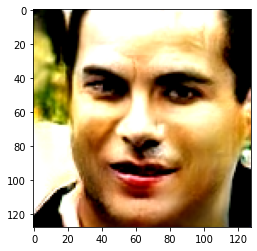

In [ ]:
latent_dim = 512
IMAGE_SIZE = (128,128)
latent_vector = tf.random.normal([1, latent_dim], seed=1000)
interpolated_images = module(latent_vector)
plt.imshow(interpolated_images.numpy().reshape((128,128,3)))
plt.show()

In [63]:
class MyDenseLayer(tf.keras.layers.Layer):
  def __init__(self, num_outputs):
    super(MyDenseLayer, self).__init__()
    self.num_outputs = num_outputs

  def build(self, input_shape):
    print(input_shape)

  def call(self, input):
    print(input)
    return input

layer = MyDenseLayer(10)
print(layer(tf.random.normal([10, 5])))
#print(layer.trainable_variables)

(10, 5)
tf.Tensor(
[[-1.508789   -0.03788033  0.15119284 -0.5473662   1.087177  ]
 [ 0.27785864 -0.58629817  0.54049516 -0.60138583 -0.48297602]
 [-0.45089304  0.06711877 -1.1484954   0.0901693  -0.29280603]
 [-0.77782106 -1.5104771  -0.697866    0.61076534  0.5426677 ]
 [-0.19548991  1.1133326  -1.3298078   0.12520619  0.77839977]
 [-2.4731505   0.70979047 -0.19913195 -0.9724329  -2.201666  ]
 [ 0.89199317  0.09167212 -0.39265132  1.1577322   0.02796225]
 [ 0.02664092 -0.03763173 -1.0530379   1.2160151  -0.0122673 ]
 [ 0.3657444   1.331804    1.4453018   1.0237848   0.40014526]
 [-0.87259316  1.6184914  -0.19320422 -0.16565752  1.0525728 ]], shape=(10, 5), dtype=float32)
tf.Tensor(
[[-1.508789   -0.03788033  0.15119284 -0.5473662   1.087177  ]
 [ 0.27785864 -0.58629817  0.54049516 -0.60138583 -0.48297602]
 [-0.45089304  0.06711877 -1.1484954   0.0901693  -0.29280603]
 [-0.77782106 -1.5104771  -0.697866    0.61076534  0.5426677 ]
 [-0.19548991  1.1133326  -1.3298078   0.12520619  0.778

In [ ]:
class PixelwiseNormalization(tf.keras.layers.Layer):
  def __init__(self):
    super(PixelwiseNormalization, self).__init__()
    
  def call(self, input):
    input_shape = input.shape
    epsillon = 10e-8
    divied = tf.keras.backend.square(input)
    divied = tf.keras.backend.sum(divied,axis=-1)
    divied = divied / tf.cast(input_shape[-1], tf.float32)
    divied = tf.keras.backend.sqrt(divied)
    divied = tf.expand_dims(divied, axis=-1)

    return input / divied

pixelwiseNormalization = PixelwiseNormalization()

In [28]:
(x_train, y_train) , (x_test, y_test) = datasets.mnist.load_data()
x_train = np.expand_dims(x_train, axis=-1)
resized_images = tf.image.resize(x_train, [32,32],method='nearest')
print(x_train.shape)

(60000, 28, 28)
(60000, 32, 32, 1)


MNIST 32x32 <br>
latent : 64 <br>
batch : 128 <br>
[128, 64, 1, 1] ->
[128, 32, 3, 3] -> 
[128, 16, 7, 7] ->
[128, 8, 14, 14] -> 
[128, 4, 28, 28] ->
[128, 1, 28, 28]


In [85]:
latent_dim = 64
batch_size = 128
generated_shape = (32,32,1)

In [83]:
generator_32 = models.Sequential()
generator_32.add(layers.Dense(64 * 2 * 2, activation="relu", input_dim=64))

generator_32.add(layers.Reshape((2,2,64)))

generator_32.add(layers.Conv2D(32,kernel_size=3,padding='same'))
generator_32.add(layers.LeakyReLU(alpha=0.2))
generator_32.add(PixelwiseNormalization())
generator_32.add(layers.Conv2D(32,kernel_size=3,padding='same'))
generator_32.add(layers.LeakyReLU(alpha=0.2))
generator_32.add(PixelwiseNormalization())
generator_32.add(layers.UpSampling2D(interpolation='nearest'))


generator_32.add(layers.Conv2D(16,kernel_size=3, padding='same'))
generator_32.add(layers.LeakyReLU(alpha=0.2))
generator_32.add(PixelwiseNormalization())
generator_32.add(layers.Conv2D(16,kernel_size=3, padding='same'))
generator_32.add(layers.LeakyReLU(alpha=0.2))
generator_32.add(PixelwiseNormalization())
generator_32.add(layers.UpSampling2D(interpolation='nearest'))


generator_32.add(layers.Conv2D(8,kernel_size=3, padding='same'))
generator_32.add(layers.LeakyReLU(alpha=0.2))
generator_32.add(PixelwiseNormalization())
generator_32.add(layers.Conv2D(8,kernel_size=3, padding='same'))
generator_32.add(layers.LeakyReLU(alpha=0.2))
generator_32.add(PixelwiseNormalization())
generator_32.add(layers.UpSampling2D(interpolation='nearest'))

generator_32.add(layers.Conv2D(4,kernel_size=3, padding='same'))
generator_32.add(layers.LeakyReLU(alpha=0.2))
generator_32.add(PixelwiseNormalization())
generator_32.add(layers.Conv2D(4,kernel_size=3, padding='same'))
generator_32.add(layers.LeakyReLU(alpha=0.2))
generator_32.add(PixelwiseNormalization())
generator_32.add(layers.UpSampling2D(interpolation='nearest'))

generator_32.add(layers.Conv2D(1,kernel_size=1, padding='same', activation='tanh'))

generator_32.summary()


Model: "sequential_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 256)               16640     
_________________________________________________________________
reshape_18 (Reshape)         (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 2, 2, 32)          18464     
_________________________________________________________________
leaky_re_lu_53 (LeakyReLU)   (None, 2, 2, 32)          0         
_________________________________________________________________
pixelwise_normalization_18 ( (None, 2, 2, 32)          0         
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 2, 2, 32)          9248      
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 2, 2, 32)        

In [90]:
dircriminator_32 = models.Sequential()

dircriminator_32.add(layers.Conv2D(4, kernel_size=1, input_shape=generated_shape, padding='same'))
dircriminator_32.add(layers.LeakyReLU(alpha=0.2))

dircriminator_32.add(layers.Conv2D(4, kernel_size=3, padding='same'))
dircriminator_32.add(layers.LeakyReLU(alpha=0.2))
dircriminator_32.add(layers.Conv2D(8, kernel_size=3, padding='same'))
dircriminator_32.add(layers.LeakyReLU(alpha=0.2))
dircriminator_32.add(layers.AveragePooling2D())

dircriminator_32.add(layers.Conv2D(8,kernel_size=3, padding='same'))
dircriminator_32.add(layers.LeakyReLU(alpha=0.2))
dircriminator_32.add(layers.Conv2D(16,kernel_size=3, padding='same'))
dircriminator_32.add(layers.LeakyReLU(alpha=0.2))
dircriminator_32.add(layers.AveragePooling2D())

dircriminator_32.add(layers.Conv2D(16,kernel_size=3, padding='same'))
dircriminator_32.add(layers.LeakyReLU(alpha=0.2))
dircriminator_32.add(layers.Conv2D(32,kernel_size=3, padding='same'))
dircriminator_32.add(layers.LeakyReLU(alpha=0.2))
dircriminator_32.add(layers.AveragePooling2D())

dircriminator_32.add(layers.Conv2D(32,kernel_size=3, padding='same'))
dircriminator_32.add(layers.LeakyReLU(alpha=0.2))
dircriminator_32.add(layers.Conv2D(64,kernel_size=3, padding='same'))
dircriminator_32.add(layers.LeakyReLU(alpha=0.2))
dircriminator_32.add(layers.AveragePooling2D())

#minibatch stddev
dircriminator_32.add(layers.Conv2D(64,kernel_size=3, padding='same'))
dircriminator_32.add(layers.LeakyReLU(alpha=0.2))
dircriminator_32.add(layers.Conv2D(64,kernel_size=3, padding='same'))
dircriminator_32.add(layers.LeakyReLU(alpha=0.2))

dircriminator_32.add(layers.Dense(1, activation='sigmoid'))
dircriminator_32.summary()


Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_126 (Conv2D)          (None, 32, 32, 4)         8         
_________________________________________________________________
leaky_re_lu_103 (LeakyReLU)  (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 32, 32, 4)         148       
_________________________________________________________________
leaky_re_lu_104 (LeakyReLU)  (None, 32, 32, 4)         0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 32, 32, 8)         296       
_________________________________________________________________
leaky_re_lu_105 (LeakyReLU)  (None, 32, 32, 8)         0         
_________________________________________________________________
average_pooling2d_19 (Averag (None, 16, 16, 8)       